The [fourth place solution](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/543672) was done by [Ravi Ramakrishnan](https://www.kaggle.com/ravi20076). A lot of his solution is within the discussion post itself, but he linked a baseline script featuring some of his process, which is shown below. 

# **FOREWORD**

This kernel is a second part to my [ML baseline public materials](https://www.kaggle.com/code/ravi20076/playgrounds4e10-imports-v1). My older kernel for Playground Baseline models became a bit clunky and needed revision. <br>
This kernel is divided into 2 parts with scripts- <br>
1. Utility script with relevant imports, package installations and model training script for all types of Playground assignments <br>
2. Model kernel using the previous step as imported script and execution of the model <br>

I wish to extend sincere thanks to the Kaggle community for the long standing support over the years! Thanks for all the feedback on my kernels and many thanks for your collective generosity!

### **WHAT IS DIFFERENT HERE** <br>
1. Usage of a utility script for imports and a general training class for all types of Playground datasets with(out) the original data <br>
2. Common training class for regression, multiclass and binary problems <br>
3. Ability to train single models one at a time <br>
4. Ability to enter a pipeline object instead of a model object for training <br>
5. Separate ensemble with facility for Optuna blending with normalised weights as output. User has full choice to implement his/ her ensemble method <br>
6. Ability to skip early stopping if needed in the pipeline <br> 
7. Compatible with any scikit-learn model/ classical ML model <br>
8. Ability to perform online full fit <br>
9. Can be used for code competitions as well, returns fitted models as one of the outputs <br>
10. Ability to load the dataset as per the choice of original dataset included/ excluded in the CV scheme <br>


## **COMPETITION AND DATASET DETAILS** <br>

This is a binary classifier to predict the probability of a customer subscribing to a loan product application. <br> **ROC-AUC Score** is the evaluation metric and needs to be maximized <br>

In this baseline kernel, I start off with simple feature engneering and ML models to initiate the process. Let's delve deeper into the challenge as we move along and improve the process! <br>

All the best!


# **IMPORTS**

We import the import script to load all the relevant packages from my utlity script alongside

In [1]:
%%time

!pip install -q -r /kaggle/input/playgrounds4e10-imports-v1/req_colab.txt

exec(open('/kaggle/input/playgrounds4e10-imports-v1/myimports.py','r').read())
exec(open('/kaggle/input/playgrounds4e10-imports-v1/training.py','r').read())

%matplotlib inline
print()

---> XGBoost = 2.1.1 | LightGBM = 4.5.0 | Catboost = 1.2.7
---> Sklearn = 1.5.2| Pandas = 2.2.2
---> Imports- part 1 done

---> Commencing imports-part2
---> XGBoost = 2.1.1 | LightGBM = 4.5.0
---> Imports- part 2 done

---> Imports done



CPU times: user 4.3 s, sys: 626 ms, total: 4.93 s
Wall time: 42.6 s


# **CONFIGURATION**

In this section, we define our configuration class with general parameters to be used through the code <br>

### **KEY NOTE** <br>

|Parameter|How to use them|
|---------| --------------|
|nb_orig  | Number of times we need to append the original data to the training data in the episode <br>0 - no need of original <br> 1 - original is appended 1 time to the competition dataset <br> 2+ - original is appended more than 1 time to the competition dataset <br><br>Ensure that the train dataset contains a column **Source == Competition** for the code to run well |
|orig_all_folds | Determines if the original dataset needs to be appended in full to every fold in the training data <br> True - appends the original in full to every fold <br> False - makes the fold using train + original |

In [2]:
%%time 

class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 1
    model_id    = "V1_2"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 0.05

    gpu_switch         = "OFF"
    state              = 42
    target             = f"loan_status"
    grouper            = f""
    tgt_mapper         = {}

    ip_path            = f"/kaggle/input/playground-series-s4e10"
    op_path            = f"/kaggle/working"
    orig_path          = f"/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv"

    dtl_preproc_req    = True
    ftre_plots_req     = True
    ftre_imp_req       = True

    nb_orig            = 1
    orig_all_folds     = True

    # Model Training:-
    pstprcs_oof        = False
    pstprcs_train      = False
    pstprcs_test       = False
    ML                 = True
    test_preds_req     = False

    pseudo_lbl_req     = "N"
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00

    n_splits           = 3 if test_req == True else 10
    n_repeats          = 1
    nbrnd_erly_stp     = 100
    mdlcv_mthd         = 'SKF'

    # Ensemble:-
    ensemble_req       = True
    optuna_req         = False
    metric_obj         = 'maximize'
    ntrials            = 10 if test_req == True else 300

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }

PrintColor(f"\n---> Configuration done!\n")

cv_selector = \
{
 "RKF"   : RKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "RSKF"  : RSKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "SKF"   : SKF(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "KF"    : KFold(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "GKF"   : GKF(n_splits = CFG.n_splits)
}

collect()


---> Configuration done!

CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 125 ms


4

|Configuration parameter| Explanation| Data type| Sample values |  
| ---------------------- | ------------------------------- | --------------------- | --------------- |
| version_nb    | Version Number | int | 1 | 
| model_id      | Model ID    | string | V1_1 | 
| model_label   | Model Label | string | ML | 
| test_req      | Test Required| bool | True / False | 
| test_sample_frac| Test sampled fraction | int | 1000 |
| gpu_switch      | Do we need GPU support | bool | True / False |
| state           | Random state | int | 42 |
| target          | Target column | str |  |
| grouper         | CV grouper column | str |  |
| ip_path, op_path | Data paths  | str | |
| pstprcs_* | Do we need post-processing  | bool |True / False |
| ML| Do we need machine learning models  | bool |True / False |
| test_preds_req| Do we need test set predictions (training in inference kernel)  | bool |True / False |
| pseudo_lbl_req| Pseudo label required?  | bool |True / False |
| pseudo_lbl_* | Pseudo label cutoff | float | |
| n_splits/ n_repeats | N-splits and repeats for CV scheme | int | 3/5/10|
| nbrnd_erly_stp | Early stopping rounds | int | 40|
| mdlcv_mthd | Model CV method | str | RSKF|
| ensemble_req | Do we need ensemble | bool | True / False |
| optuna_req   | Do we need optuna | bool | True / False |
| metric_obj   | Metric direction | str | minimize/ maximize |
| ntrials      | Trials | int | 300 |

# **PREPROCESSING**

In [3]:
%%time 

exec(open('/kaggle/input/playgrounds4e10-imports-v1/mypp.py','r').read())

pp = Preprocessor()
pp.DoPreprocessing();



Data shapes - train-test-original | (58645, 12) (39098, 11) (32581, 12)

Train set head


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.000,EDUCATION,B,6000,11.490,0.170,N,14,0
1,22,56000,OWN,6.000,MEDICAL,C,4000,13.350,0.070,N,2,0
2,29,28800,OWN,8.000,PERSONAL,A,6000,8.900,0.210,N,10,0
3,30,70000,RENT,14.000,VENTURE,B,12000,11.110,0.170,N,5,0
4,22,60000,RENT,2.000,MEDICAL,A,6000,6.920,0.100,N,3,0



Test set head


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.000,HOMEIMPROVEMENT,F,25000,15.760,0.360,N,2
58646,26,96000,MORTGAGE,6.000,PERSONAL,C,10000,12.680,0.100,Y,4
58647,26,30000,RENT,5.000,VENTURE,E,4000,17.190,0.130,Y,2
58648,33,50000,RENT,4.000,DEBTCONSOLIDATION,A,7000,8.900,0.140,N,7
58649,26,102000,MORTGAGE,8.000,HOMEIMPROVEMENT,D,15000,16.320,0.150,Y,4



Original set head


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,0.590,Y,3,1
1,21,9600,OWN,5.000,EDUCATION,B,1000,11.140,0.100,N,2,0
2,25,9600,MORTGAGE,1.000,MEDICAL,C,5500,12.870,0.570,N,3,1
3,23,65500,RENT,4.000,MEDICAL,C,35000,15.230,0.530,N,2,1
4,24,54400,RENT,8.000,MEDICAL,C,35000,14.270,0.550,Y,4,1




Train shape before conjoining with original = (58645, 13)
Train shape after conjoining with original= (91226, 13)
CPU times: user 631 ms, sys: 54.3 ms, total: 685 ms
Wall time: 783 ms


# **EDA**

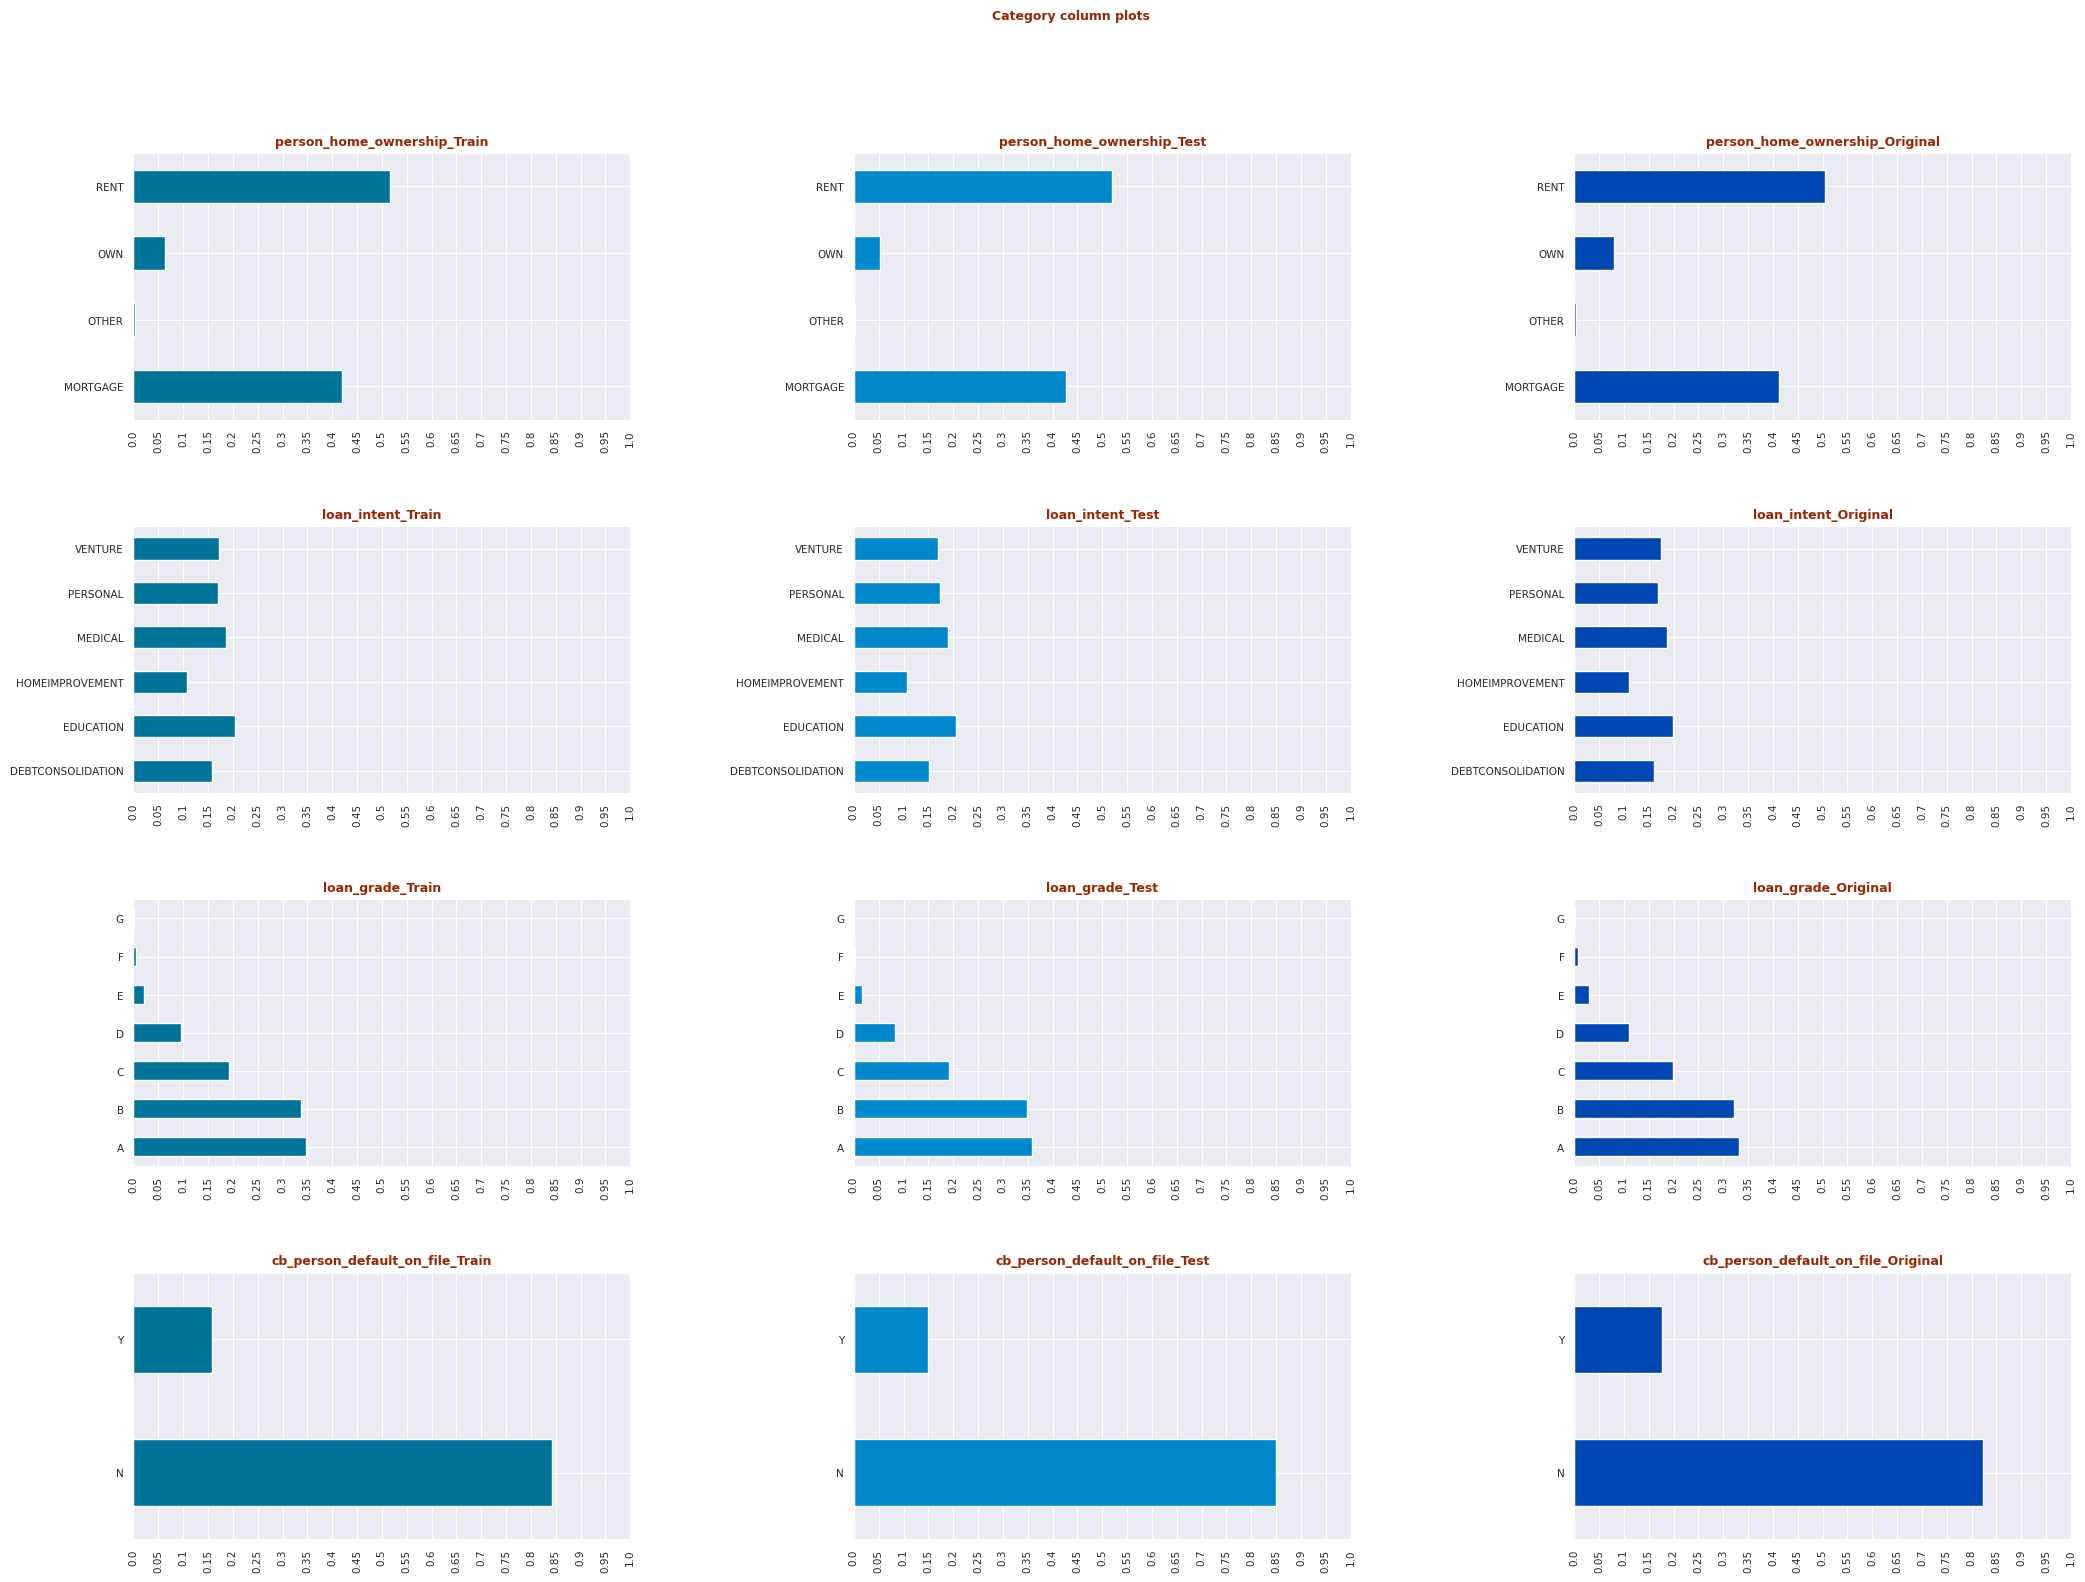

CPU times: user 5.26 s, sys: 289 ms, total: 5.54 s
Wall time: 5.21 s


In [4]:
%%time 

plotter = \
FeaturePlotter(
    target = CFG.target, 
    ftre_plots_req = CFG.ftre_plots_req, 
    title_specs = CFG.title_specs, 
    grid_specs = CFG.grid_specs
)

plotter.MakeCatFtrePlots(
    pp.cat_cols, pp.train, pp.test, pp.original
)

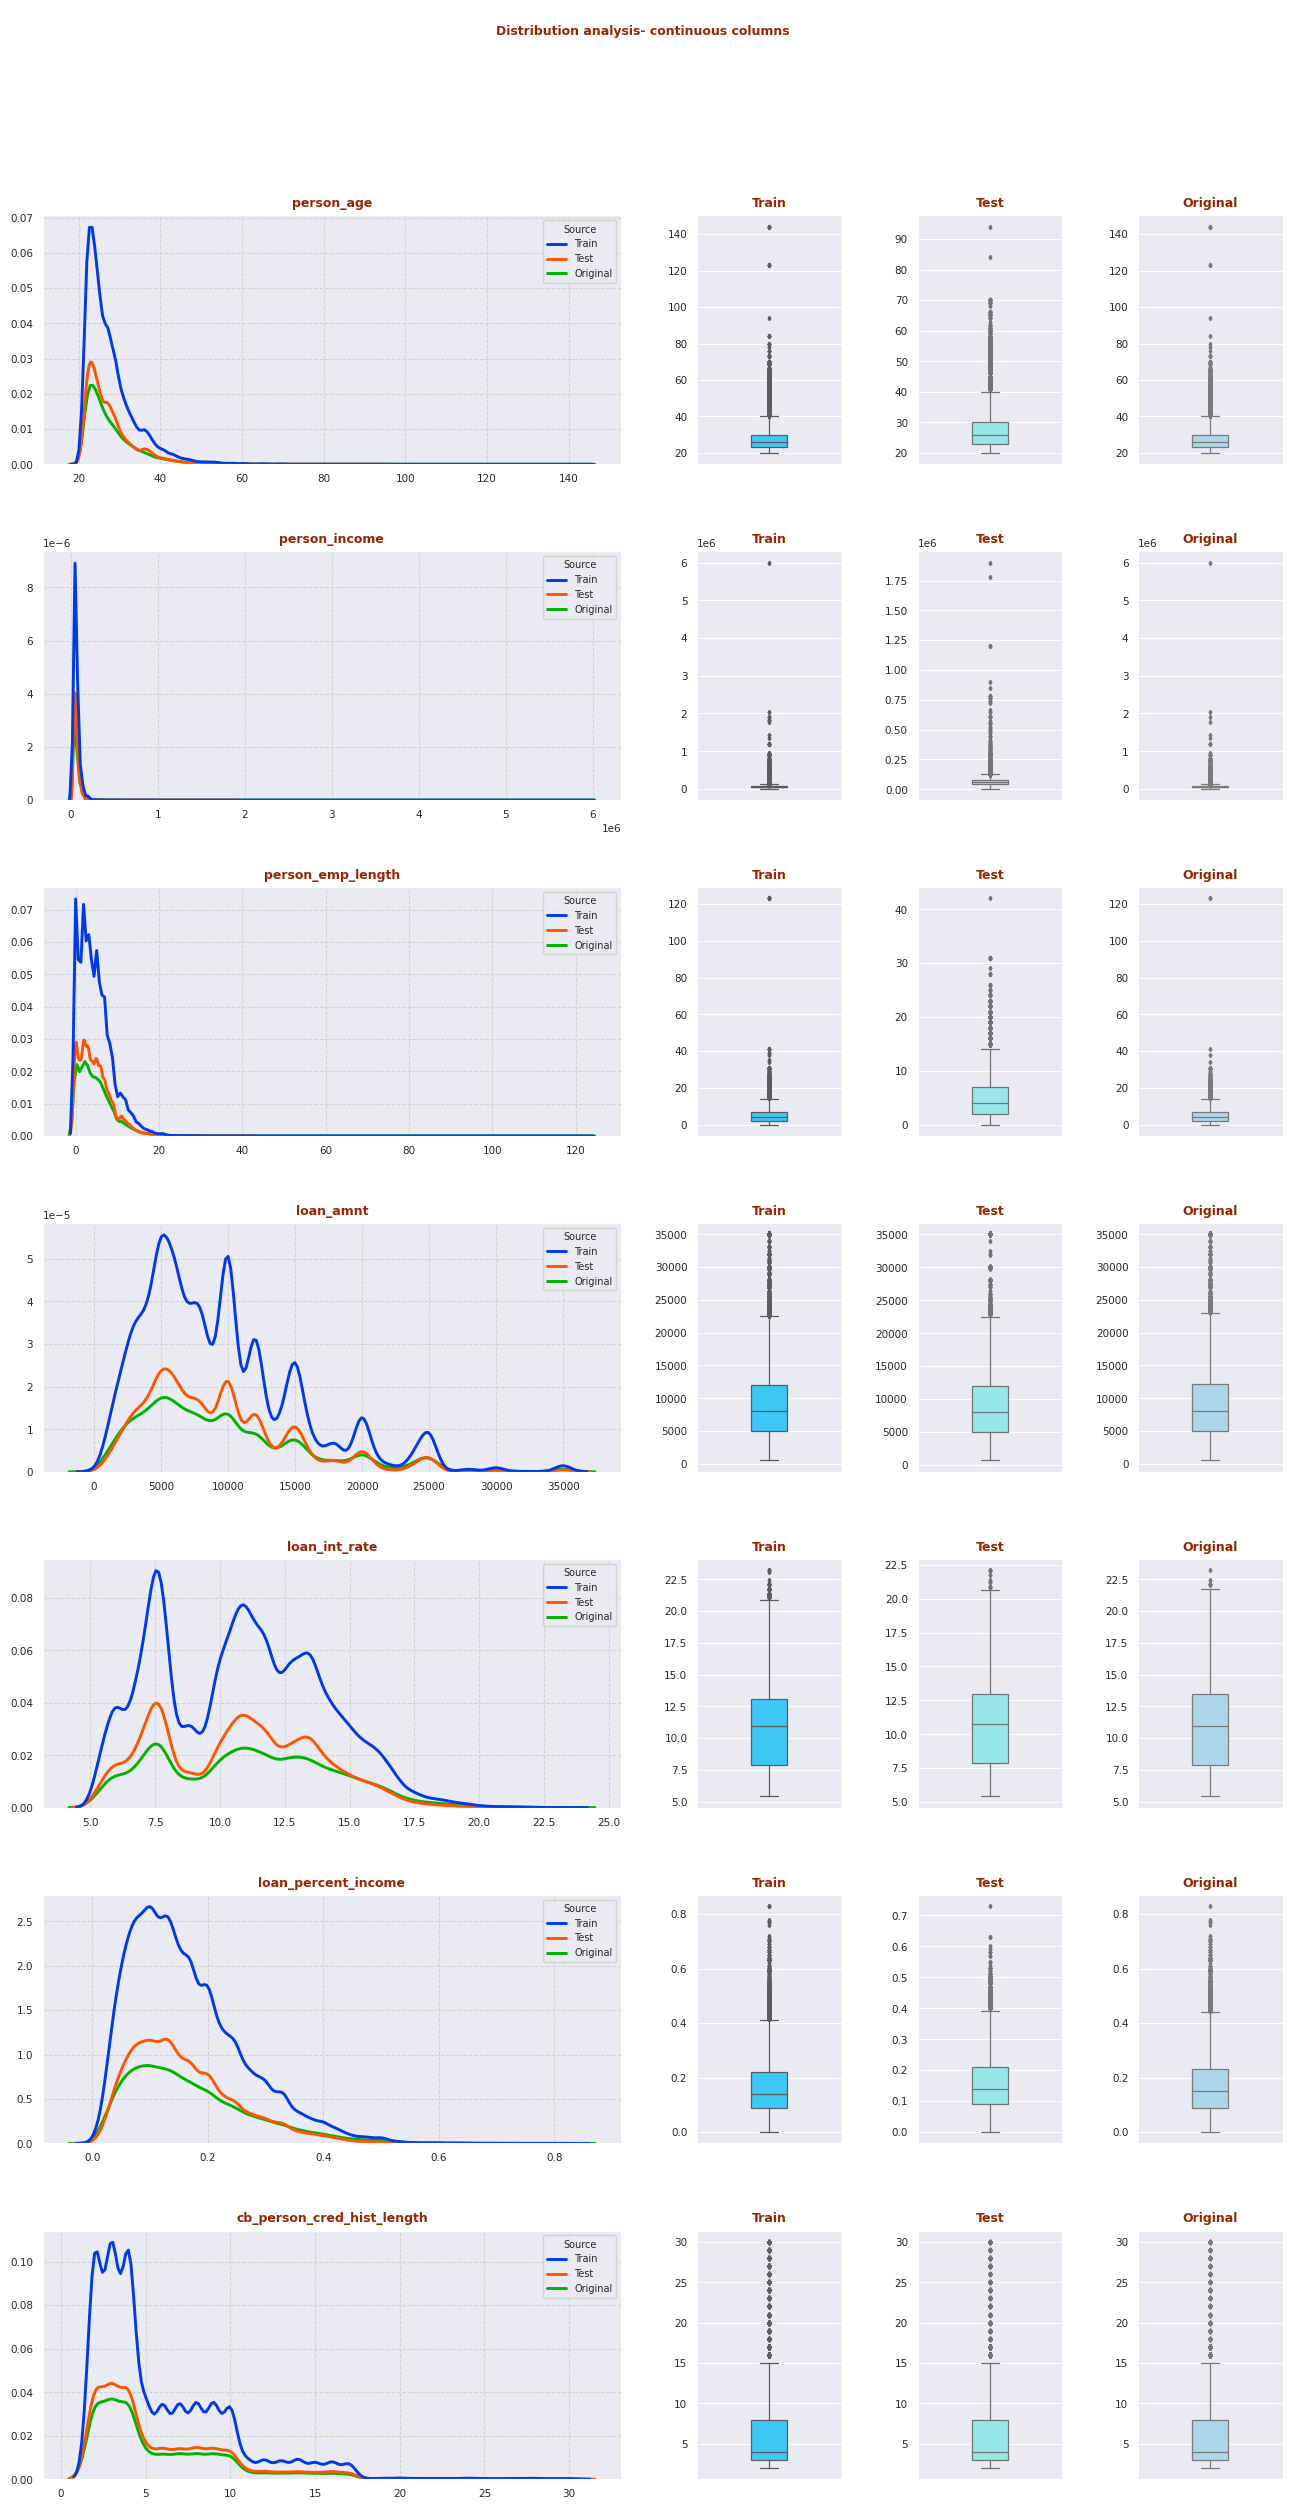

CPU times: user 21.3 s, sys: 2.54 s, total: 23.8 s
Wall time: 15.7 s


In [5]:
%%time 

plotter.MakeContColPlots(
    pp.cont_cols, pp.train, pp.test, pp.original
)

Target plot- loan_status ---> : 0it [00:00, ?it/s]

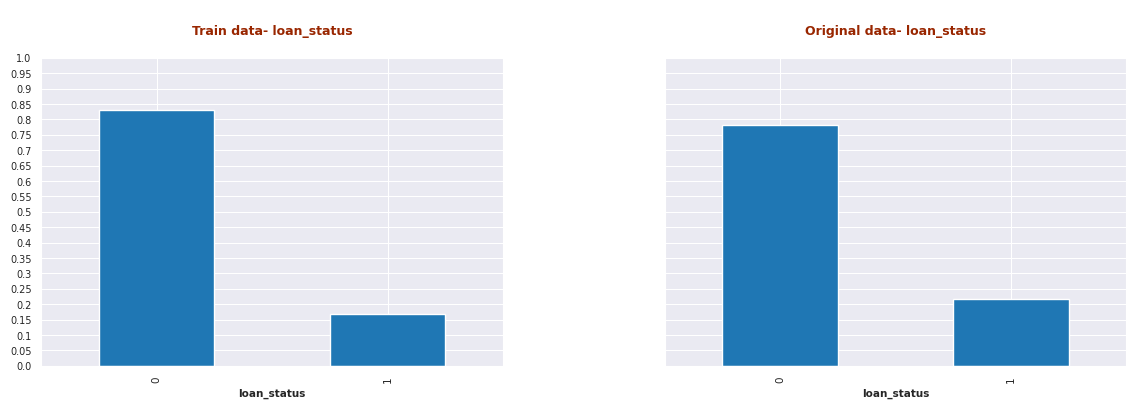

CPU times: user 751 ms, sys: 159 ms, total: 911 ms
Wall time: 659 ms


In [6]:
%%time 

plotter.MakeTgtPlot(pp.train, pp.original)

In [7]:
%%time 

plotter.CalcSkew(
    pp.cont_cols, pp.train, pp.test, pp.original
)


Skewness across independent features



,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
Train,2.21,28.73,2.27,1.21,0.21,1.01,1.63
Test,1.94,10.45,1.16,1.20,0.19,0.94,1.65
Original,2.58,32.87,2.61,1.19,0.21,1.06,1.66


CPU times: user 45.6 ms, sys: 1.05 ms, total: 46.6 ms
Wall time: 44.8 ms


### **INFERENCES**


1. The competition training data has a slightly higher share of class 0 elements than the original <br>
2. Skewness of features is slightly higher in the original compared to the competition dataset. Skewness between train-test sets looks a bit different across age, employment length and income columns <br>
3. Loan percent income column can be calculated from the component parts- loan value (probably an EMI amount and the monthly income). In several cases, the ratio and the components are off <br>
4. We can observe some anomalies in the interest rates in certain loans- this could be due to the synthetic data creation process <br>
5. We have a lot of younger customers in the data - Age has a median of 26 years and a mean of 27 years <br>


## **ANCILLARY EDA**

In [8]:
%%time 

df1 = pp.train[["person_age", CFG.target]]
df1["age_grp"] = pd.cut(df1["person_age"], bins = [-1* np.inf, 21, 25, 30, 35, 40, 45, 50, 60, np.inf])
df1 = df1.groupby("age_grp").agg({CFG.target : ["mean",]})
df1.columns = ["OVERALL"]

df = pp.train[["person_age", CFG.target, "loan_intent"]]
df["age_grp"] = \
pd.cut(df["person_age"], 
       bins = [-1* np.inf, 21, 25, 30, 35, 40, 45, 50, 60, np.inf]
      )

df = \
pd.crosstab(
    index = df["age_grp"], 
    columns = df["loan_intent"], 
    values = df[CFG.target], 
    aggfunc = np.mean
)

df = pd.concat([df, df1], axis=1)
display(
    df.style.\
    highlight_max(
        props = "color:blue; background-color:white;font-weight:bold;border:dashed maroon 1.5px"
    ).\
    highlight_min(
        props = "color:red; background-color:white;font-weight:bold;border:dashed blue 1.5px"
    ).\
    format(formatter = '{:.3%}').\
    set_caption(f"Loan application by age groups")
)

print();

,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,OVERALL
age_grp,,,,,,,
"(-inf, 21.0]",25.000%,12.907%,97.872%,29.675%,23.034%,16.211%,22.419%
"(21.0, 25.0]",22.609%,11.711%,28.761%,21.823%,16.866%,12.302%,17.364%
"(25.0, 30.0]",21.651%,13.803%,15.644%,19.555%,14.483%,10.136%,15.960%
"(30.0, 35.0]",21.494%,15.102%,17.028%,18.783%,13.460%,11.022%,16.199%
"(35.0, 40.0]",22.274%,16.933%,15.789%,20.386%,14.793%,9.193%,16.362%
"(40.0, 45.0]",22.468%,18.902%,16.558%,22.896%,16.169%,7.264%,17.384%
"(45.0, 50.0]",31.579%,13.333%,15.894%,23.353%,14.907%,4.861%,16.972%
"(50.0, 60.0]",44.828%,33.333%,30.769%,42.857%,12.000%,21.538%,21.841%
"(60.0, inf]",69.231%,20.000%,75.000%,17.500%,11.111%,0.000%,20.134%



CPU times: user 464 ms, sys: 11.8 ms, total: 476 ms
Wall time: 485 ms


In [9]:
%%time 

df = pp.train[["cb_person_default_on_file", CFG.target, 'person_age']]
df["age_grp"] = \
pd.cut(df["person_age"], 
       bins = [-1* np.inf, 21, 25, 30, 35, 40, 45, 50, 60, np.inf]
      )
df = \
pd.crosstab(
    index = df["age_grp"], 
    columns = df["cb_person_default_on_file"], 
    values = df[CFG.target], 
    aggfunc = np.mean
)

display(
    df.style.\
    highlight_max(
        props = "color:blue; background-color:white;font-weight:bold;border:dashed maroon 1.5px",
    ).\
    highlight_min(
        props = "color:red; background-color:white;font-weight:bold;border:dashed blue 1.5px",
    ).\
    format(formatter = '{:.3%}').\
    set_caption(f"Loan application by age groups and defaulter status")
)

print();

cb_person_default_on_file,N,Y
age_grp,,
"(-inf, 21.0]",19.014%,40.928%
"(21.0, 25.0]",14.227%,34.081%
"(25.0, 30.0]",13.027%,31.755%
"(30.0, 35.0]",13.372%,31.072%
"(35.0, 40.0]",13.424%,31.495%
"(40.0, 45.0]",14.263%,32.398%
"(45.0, 50.0]",14.644%,32.456%
"(50.0, 60.0]",18.846%,34.711%
"(60.0, inf]",16.529%,35.714%



CPU times: user 339 ms, sys: 767 µs, total: 340 ms
Wall time: 338 ms


In [10]:
%%time 

df = \
pd.crosstab(
    index   = pp.train["person_home_ownership"],
    columns = pp.train["loan_intent"],
    values  = pp.train[CFG.target],
    aggfunc = np.mean
)

display(
    df.style.\
    highlight_max(
        props = "color:blue; background-color:white;font-weight:bold;border:dashed maroon 1.5px",
        axis=1
    ).\
    highlight_min(
        props = "color:red; background-color:white;font-weight:bold;border:dashed blue 1.5px",
        axis=1
    ).\
    format(formatter = '{:.3%}').\
    set_caption(f"Loan application by home ownership and loan intent")
)

collect();

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
person_home_ownership,,,,,,
MORTGAGE,13.827%,5.256%,8.564%,15.096%,5.803%,2.518%
OTHER,33.333%,23.529%,22.727%,45.833%,29.268%,6.250%
OWN,29.565%,2.780%,5.814%,6.541%,3.479%,1.902%
RENT,29.276%,20.228%,37.240%,25.755%,25.849%,21.240%


CPU times: user 167 ms, sys: 998 µs, total: 168 ms
Wall time: 167 ms


In [11]:
%%time 

display(
    pp.train[["person_age", "person_emp_length", CFG.target]].\
    groupby(
        pd.cut(pp.train["person_age"], 
               bins = [-1* np.inf, 21, 25, 30, 35, 40, 45, 50, 60, np.inf]
              )
    ).\
    agg({CFG.target : 'mean', 
         "person_emp_length" : ["mean", "median", "min", "max"]}
       )
)

loan_status person_emp_length                   
                    mean              mean median  min    max
person_age                                                   
(-inf, 21.0]    0.224189          3.389333    4.0  0.0  123.0
(21.0, 25.0]    0.173644          4.137685    4.0  0.0  123.0
(25.0, 30.0]    0.159596          5.193516    4.0  0.0  123.0
(30.0, 35.0]    0.161992          5.368310    4.0  0.0   21.0
(35.0, 40.0]    0.163621          5.424469    4.0  0.0   31.0
(40.0, 45.0]    0.173837          6.091837    4.0  0.0   41.0
(45.0, 50.0]    0.169725          6.114319    4.0  0.0   31.0
(50.0, 60.0]    0.218409          4.956113    3.0  0.0   41.0
(60.0, inf]     0.201342          5.222973    3.0  0.0   41.0

CPU times: user 35.5 ms, sys: 1.95 ms, total: 37.4 ms
Wall time: 42.4 ms


### **INFERENCES**

1. Age group 50-60 applying for venture loans appears a bit grotesque <br>
2. Medical and education loans peak up for age groups 50-60 <br>
3. Home improvement and personal loans peak up for the youngst population group <br>
4. Debt consolidation peaks up for the senior citizens <br>
5. Target in line with default status peaks up for the youngest population group and flows downward till 30-35 age bracket and then consolidates <br>
6. Employment length correctly peaks up till middle age and then falls off for the senior citizens indicating retirement. Employment length = 123 for the youngest population is surely an anomaly <br>

# **DATA TRANSFORMS**

In [12]:
%%time 

def MakeFtre(X: pd.DataFrame, cat_cols: list):
    "This function makes extra features for the dataset provided"
    
    df = X.copy()
    df["loantoincome"] = (df["loan_amnt"] / df["person_income"]) - df["loan_percent_income"]
    
    df[cat_cols] = df[cat_cols].astype("category")
    return df

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.4 µs


In [13]:
%%time 

ytrain = pp.train[CFG.target]
Xtrain = pp.train.drop([CFG.target, CFG.grouper], axis= 1, errors = "ignore")
PrintColor(f"---> Shapes = {Xtrain.shape} {ytrain.shape} {pp.test.shape}")

cat_mdl_cols = \
list(pp.test.select_dtypes([np.int8, np.int16, np.int32, np.int64]).columns) + pp.cat_cols

Xtrain = MakeFtre(Xtrain, cat_mdl_cols)
Xtest  = MakeFtre(pp.test, cat_mdl_cols)

PrintColor(f"---> Shapes = {Xtrain.shape} {ytrain.shape} {Xtest.shape}")

# Initializing the cv scheme:-
cv = cv_selector[CFG.mdlcv_mthd]

if CFG.nb_orig > 0:
    all_df = []
    
    for mysource in ["Competition", "Original"]:
        df = pd.concat([Xtrain.loc[Xtrain.Source == mysource], ytrain], axis=1, join = "inner")
        df.index = range(len(df))
        for fold_nb, (_, dev_idx) in enumerate(cv.split(df, df[CFG.target])):
            df.loc[dev_idx, "fold_nb"] = fold_nb
            
        all_df.append(df)      
    ygrp = pd.concat(all_df, axis=0, ignore_index = True)["fold_nb"].astype(np.uint8)
                      
else:
    df = Xtrain.loc[Xtrain.Source == "Competition"]
    df.index = range(len(df))
    
    for fold_nb, (_, dev_idx) in enumerate(cv.split(df, ytrain.iloc[df.index])):
        df.loc[dev_idx, "fold_nb"] = fold_nb 
    ygrp = df["fold_nb"].astype(np.uint8)

---> Shapes = (91226, 12) (91226,) (39098, 12)
---> Shapes = (91226, 13) (91226,) (39098, 13)
CPU times: user 207 ms, sys: 14 ms, total: 221 ms
Wall time: 223 ms


# **MODEL TRAINING**

In [14]:
try:
    l = MyLogger()
    l.init(logging_lbl = "lightgbm_custom")
    lgb.register_logger(l)
except:
    pass

# Initializing model parameters
Mdl_Master = \
{
 f'LGBM1C' : LGBMC(**{"objective"           : "binary",
                      "metrics"             : "auc",
                      'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                      'learning_rate'       : 0.0325, 
                      'n_estimators'        : 5_000,
                      'max_depth'           : 7, 
                      'num_leaves'          : 25, 
                      'min_data_in_leaf'    : 20,
                      'feature_fraction'    : 0.70, 
                      'bagging_fraction'    : 0.88, 
                      'bagging_freq'        : 6, 
                      'lambda_l1'           : 0.001, 
                      'lambda_l2'           : 0.1,
                      'verbosity'           : -1,
                      'random_state'        : CFG.state,
                     }
                  ),

 f'LGBM2C' : LGBMC(**{"objective"           : "binary",
                      "metrics"             : "auc",
                      'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                      'learning_rate'       : 0.035,
                      'data_sample_strategy': 'goss', 
                      'n_estimators'        : 5_000,
                      'max_depth'           : 7, 
                      'num_leaves'          : 30, 
                      'min_data_in_leaf'    : 30,
                      'feature_fraction'    : 0.60, 
                      'colsample_bytree'    : 0.65,
                      'lambda_l1'           : 0.001, 
                      'lambda_l2'           : 1.25,
                      'verbosity'           : -1,
                      'random_state'        : CFG.state,
                     }
                  ),
    
    
 f'XGB1C' : XGBC(**{  "objective"             : "binary:logistic",
                      "eval_metric"           : "auc", 
                      'device'                : "cuda" if CFG.gpu_switch == "ON" else "cpu",
                      'learning_rate'         : 0.03, 
                      'n_estimators'          : 5_000,
                      'max_depth'             : 7, 
                      'colsample_bytree'      : 0.75, 
                      'colsample_bynode'      : 0.85,
                      'colsample_bylevel'     : 0.45,                     
                      'reg_alpha'             : 0.001, 
                      'reg_lambda'            : 0.25,
                      'verbose'               : 0,
                      'random_state'          : CFG.state,
                      'enable_categorical'    : True,
                      'callbacks'             : [XGBLogging(epoch_log_interval= 0)],
                      'early_stopping_rounds' : CFG.nbrnd_erly_stp, 
                     }
                  ),
    
 f'CB1C' : CBC(**{'task_type'           : "CPU",
                  'loss_function'       : 'Logloss',
                  'eval_metric'         : "AUC",
                  'bagging_temperature' : 0.25,
                  'colsample_bylevel'   : 0.40,
                  'iterations'          : 5_000,
                  'learning_rate'       : 0.045,
                  'max_depth'           : 7,
                  'l2_leaf_reg'         : 0.80,
                  'min_data_in_leaf'    : 30,
                  'random_strength'     : 0.25,
                  'verbose'             : 0,
                  'cat_features'        : cat_mdl_cols,
                 }
              ),
}

# Initializing model outputs
OOF_Preds    = {}
Mdl_Preds    = {}
FittedModels = {}
FtreImp      = {}
SelMdlCols   = {}




## **SINGLE MODELS**

  0%|          | 0/4 [00:00<?, ?it/s]


==================== LGBM1C MODEL TRAINING ====================

Selected columns = 13


0it [00:00, ?it/s]


---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM1C Fold0         OOF = 0.964955 | Train = 0.981079 | Iter = 542 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM1C Fold1         OOF = 0.959096 | Train = 0.981119 | Iter = 534 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM1C Fold2         OOF = 0.970784 | Train = 0.982144 | Iter = 598 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM1C Fold3         OOF = 0.970413 | Train = 0.986480 | Iter = 810 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM1C Fold4         OOF = 0.967417 | Train = 0.981744 | Iter = 570 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
LGBM1C Fold5         OOF = 0.965628 | Train = 0.983104 | Iter = 634 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
LGBM1C Fold6         OOF = 0.968209 | Train = 0.978727 | Iter = 456 

---> 

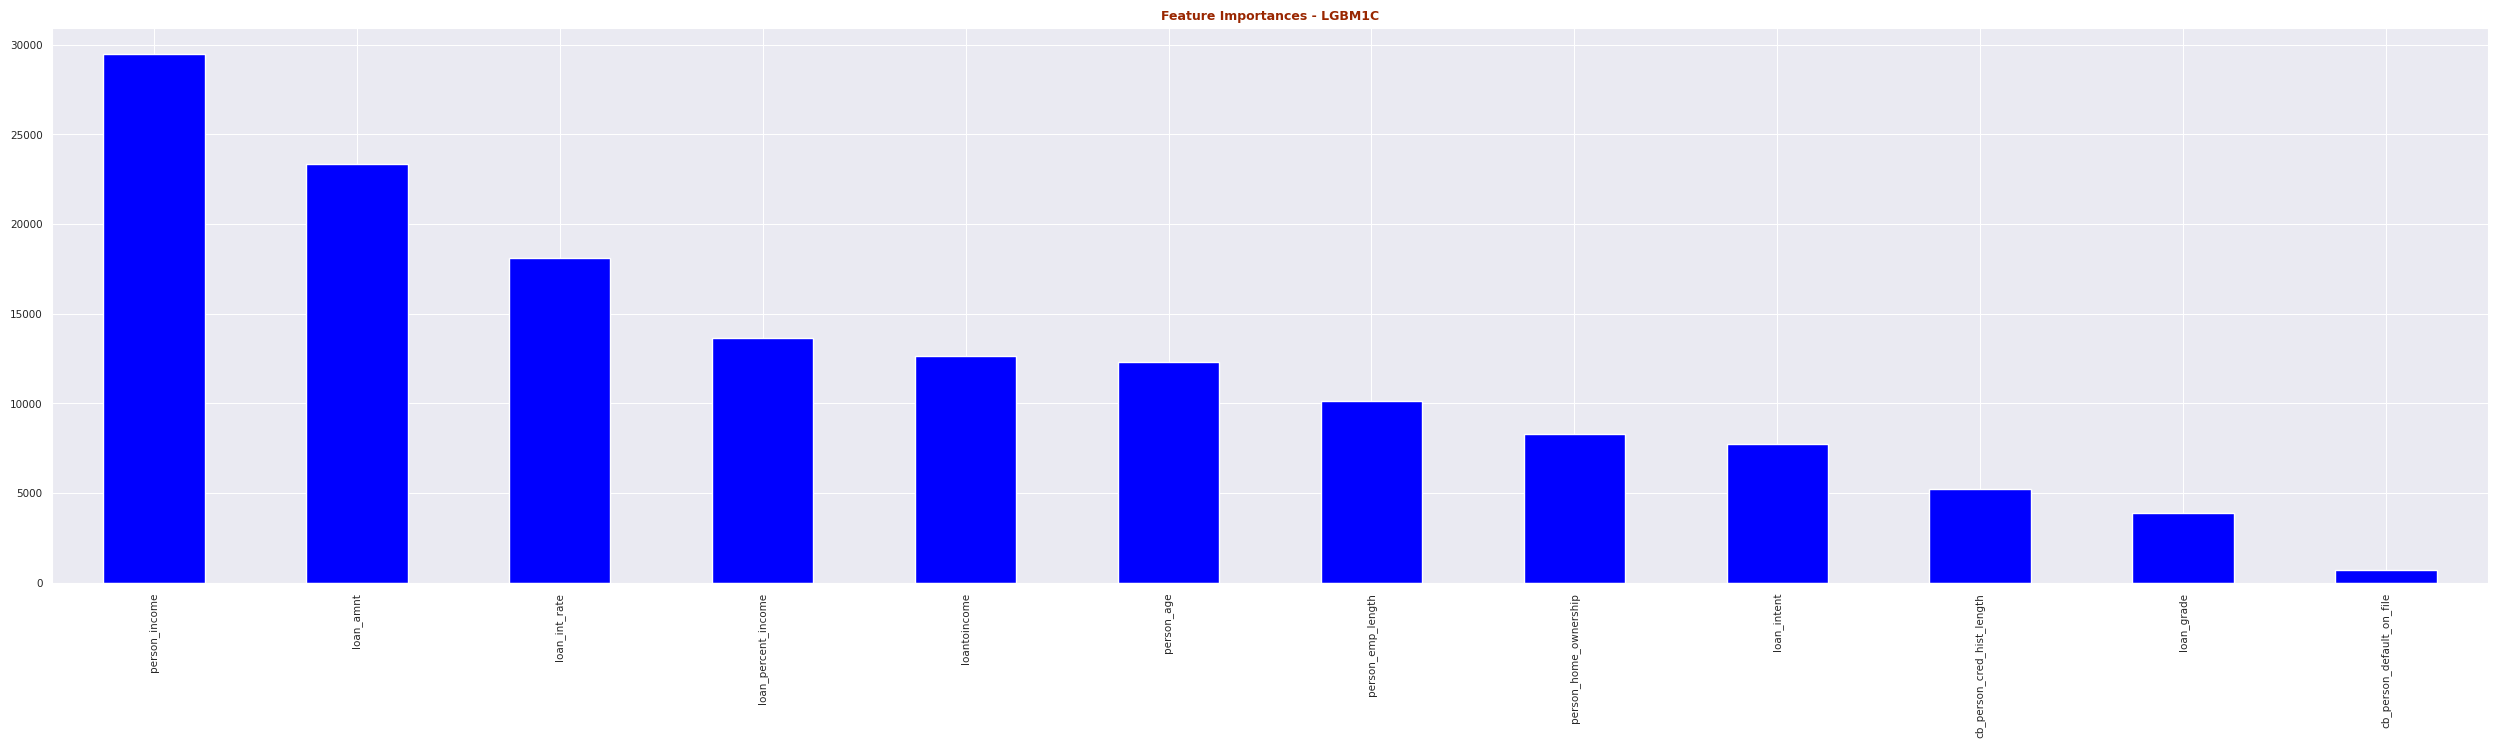



---> 0.966536 +- 0.003264 | OOF
---> 0.982386 +- 0.002091 | Train
---> Max best iteration = 810
---> Collecting original predictions


==================== LGBM2C MODEL TRAINING ====================

Selected columns = 13


0it [00:00, ?it/s]


---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM2C Fold0         OOF = 0.965126 | Train = 0.982662 | Iter = 627 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM2C Fold1         OOF = 0.959323 | Train = 0.986343 | Iter = 815 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM2C Fold2         OOF = 0.971263 | Train = 0.977290 | Iter = 446 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM2C Fold3         OOF = 0.970362 | Train = 0.983195 | Iter = 670 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
LGBM2C Fold4         OOF = 0.967104 | Train = 0.977736 | Iter = 452 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
LGBM2C Fold5         OOF = 0.965317 | Train = 0.979925 | Iter = 522 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
LGBM2C Fold6         OOF = 0.967771 | Train = 0.976781 | Iter = 424 

---> 

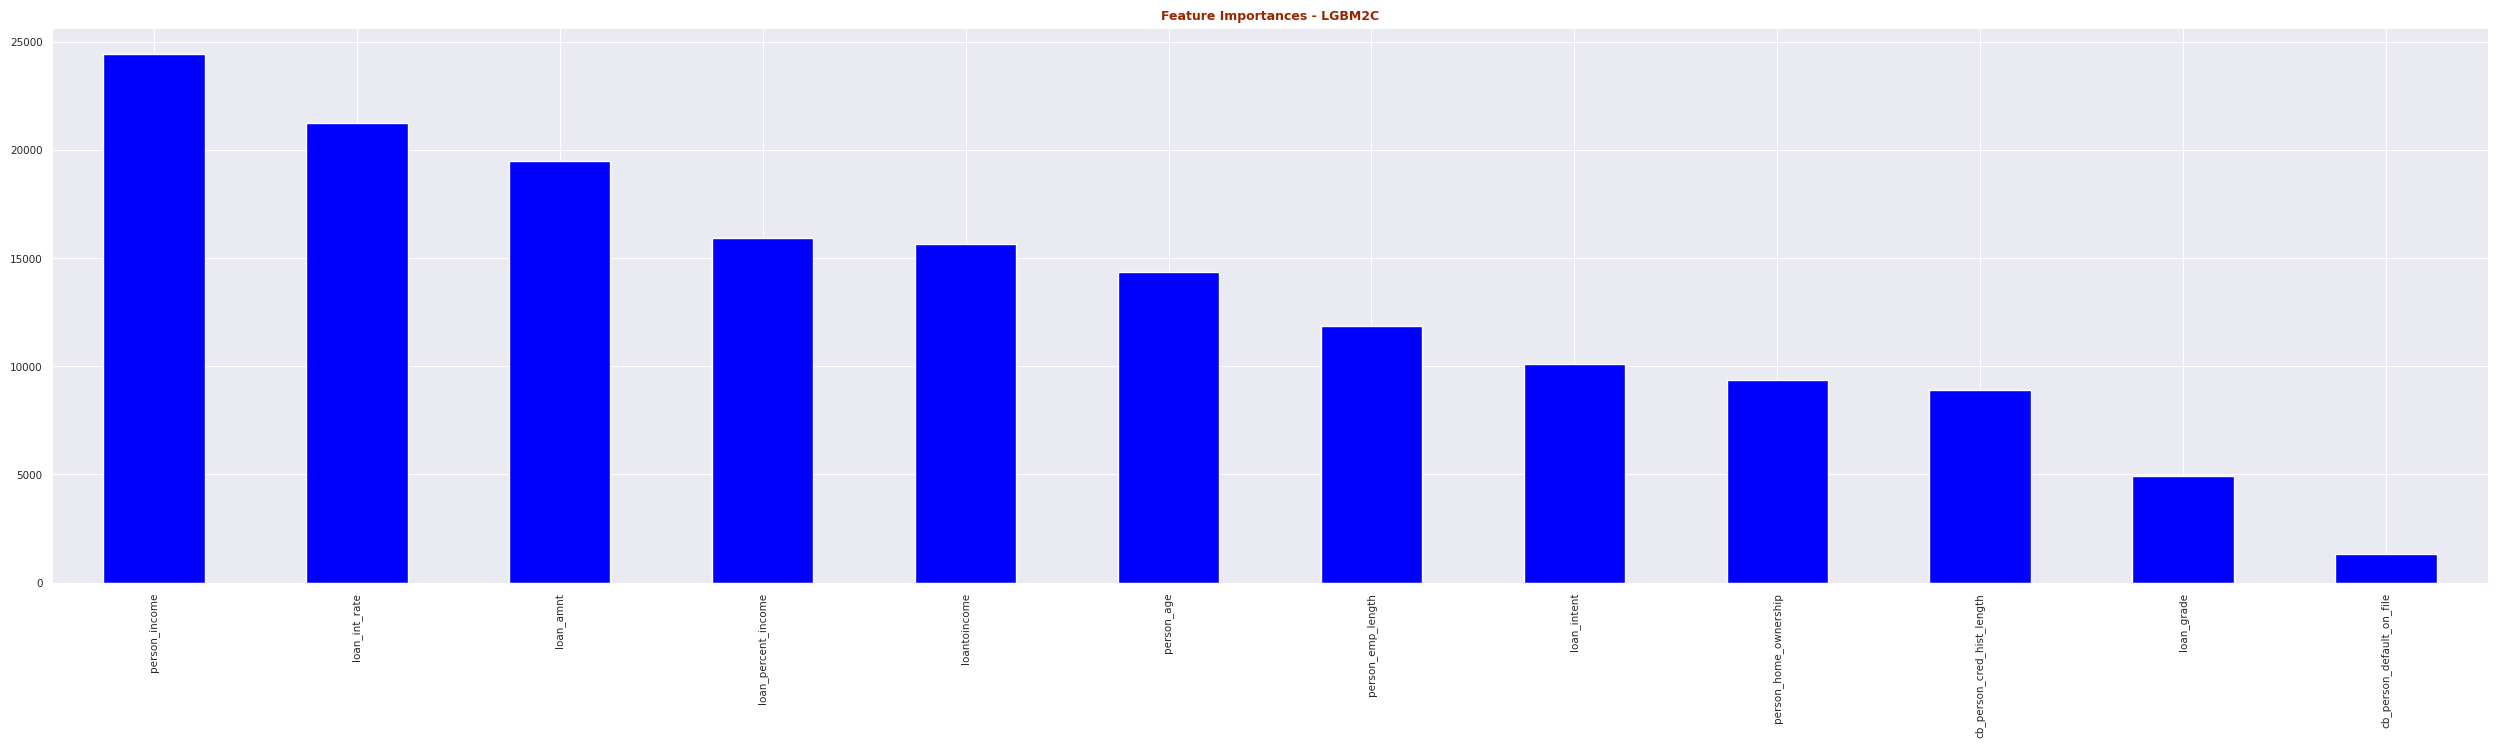



---> 0.966514 +- 0.003279 | OOF
---> 0.980082 +- 0.003123 | Train
---> Max best iteration = 815
---> Collecting original predictions


==================== XGB1C MODEL TRAINING ====================

Selected columns = 13


0it [00:00, ?it/s]


---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
XGB1C Fold0          OOF = 0.964418 | Train = 0.978175 | Iter = 233 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
XGB1C Fold1          OOF = 0.961334 | Train = 0.994916 | Iter = 882 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
XGB1C Fold2          OOF = 0.971242 | Train = 0.984645 | Iter = 411 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
XGB1C Fold3          OOF = 0.970624 | Train = 0.990860 | Iter = 630 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
XGB1C Fold4          OOF = 0.966784 | Train = 0.979640 | Iter = 262 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
XGB1C Fold5          OOF = 0.965400 | Train = 0.985553 | Iter = 412 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
XGB1C Fold6          OOF = 0.968111 | Train = 0.980001 | Iter = 264 

---> 

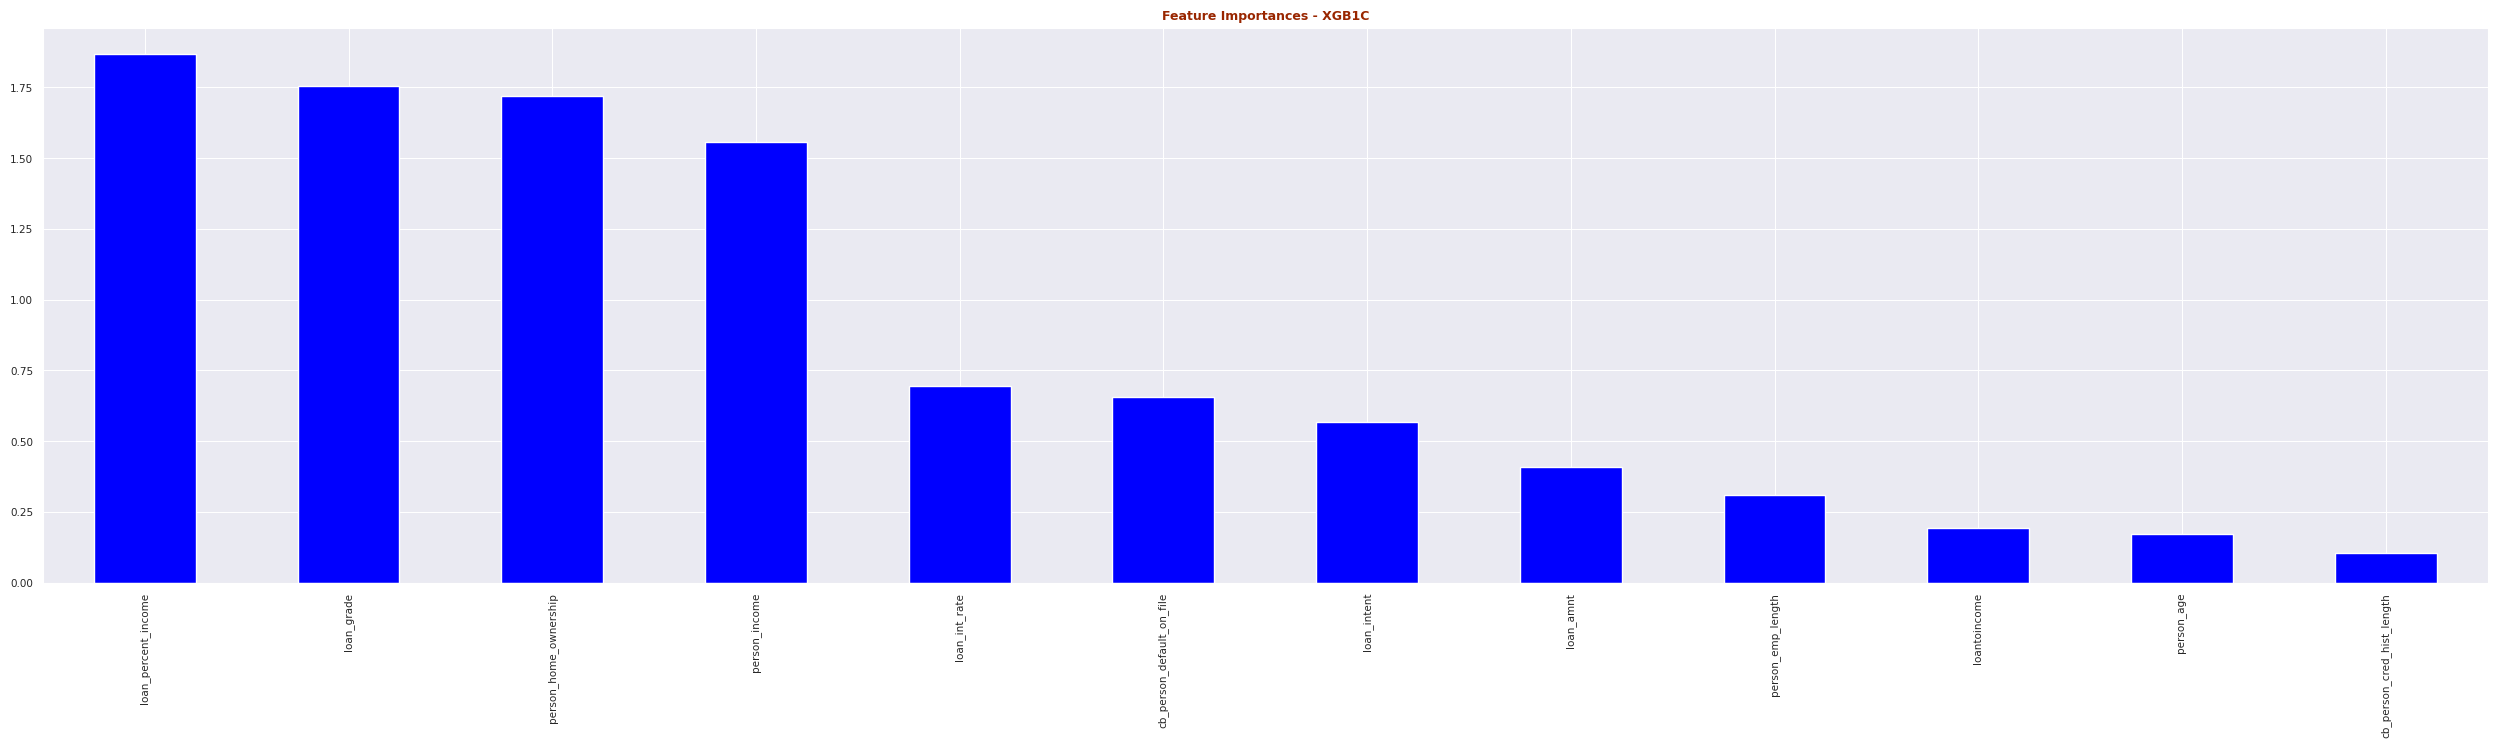



---> 0.966909 +- 0.002869 | OOF
---> 0.983376 +- 0.005448 | Train
---> Max best iteration = 882
---> Collecting original predictions


==================== CB1C MODEL TRAINING ====================

Selected columns = 13


0it [00:00, ?it/s]


---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
CB1C Fold0           OOF = 0.967133 | Train = 0.988256 | Iter = 951 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
CB1C Fold1           OOF = 0.961853 | Train = 0.989370 | Iter = 1,270 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
CB1C Fold2           OOF = 0.972224 | Train = 0.986582 | Iter = 735 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
CB1C Fold3           OOF = 0.971091 | Train = 0.984252 | Iter = 681 

---> Shapes = (85361, 12) (85361,) -- (5865, 12) (5865,) -- (39098, 12)
CB1C Fold4           OOF = 0.968248 | Train = 0.985141 | Iter = 793 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
CB1C Fold5           OOF = 0.967916 | Train = 0.987328 | Iter = 943 

---> Shapes = (85362, 12) (85362,) -- (5864, 12) (5864,) -- (39098, 12)
CB1C Fold6           OOF = 0.969580 | Train = 0.982838 | Iter = 487 

---

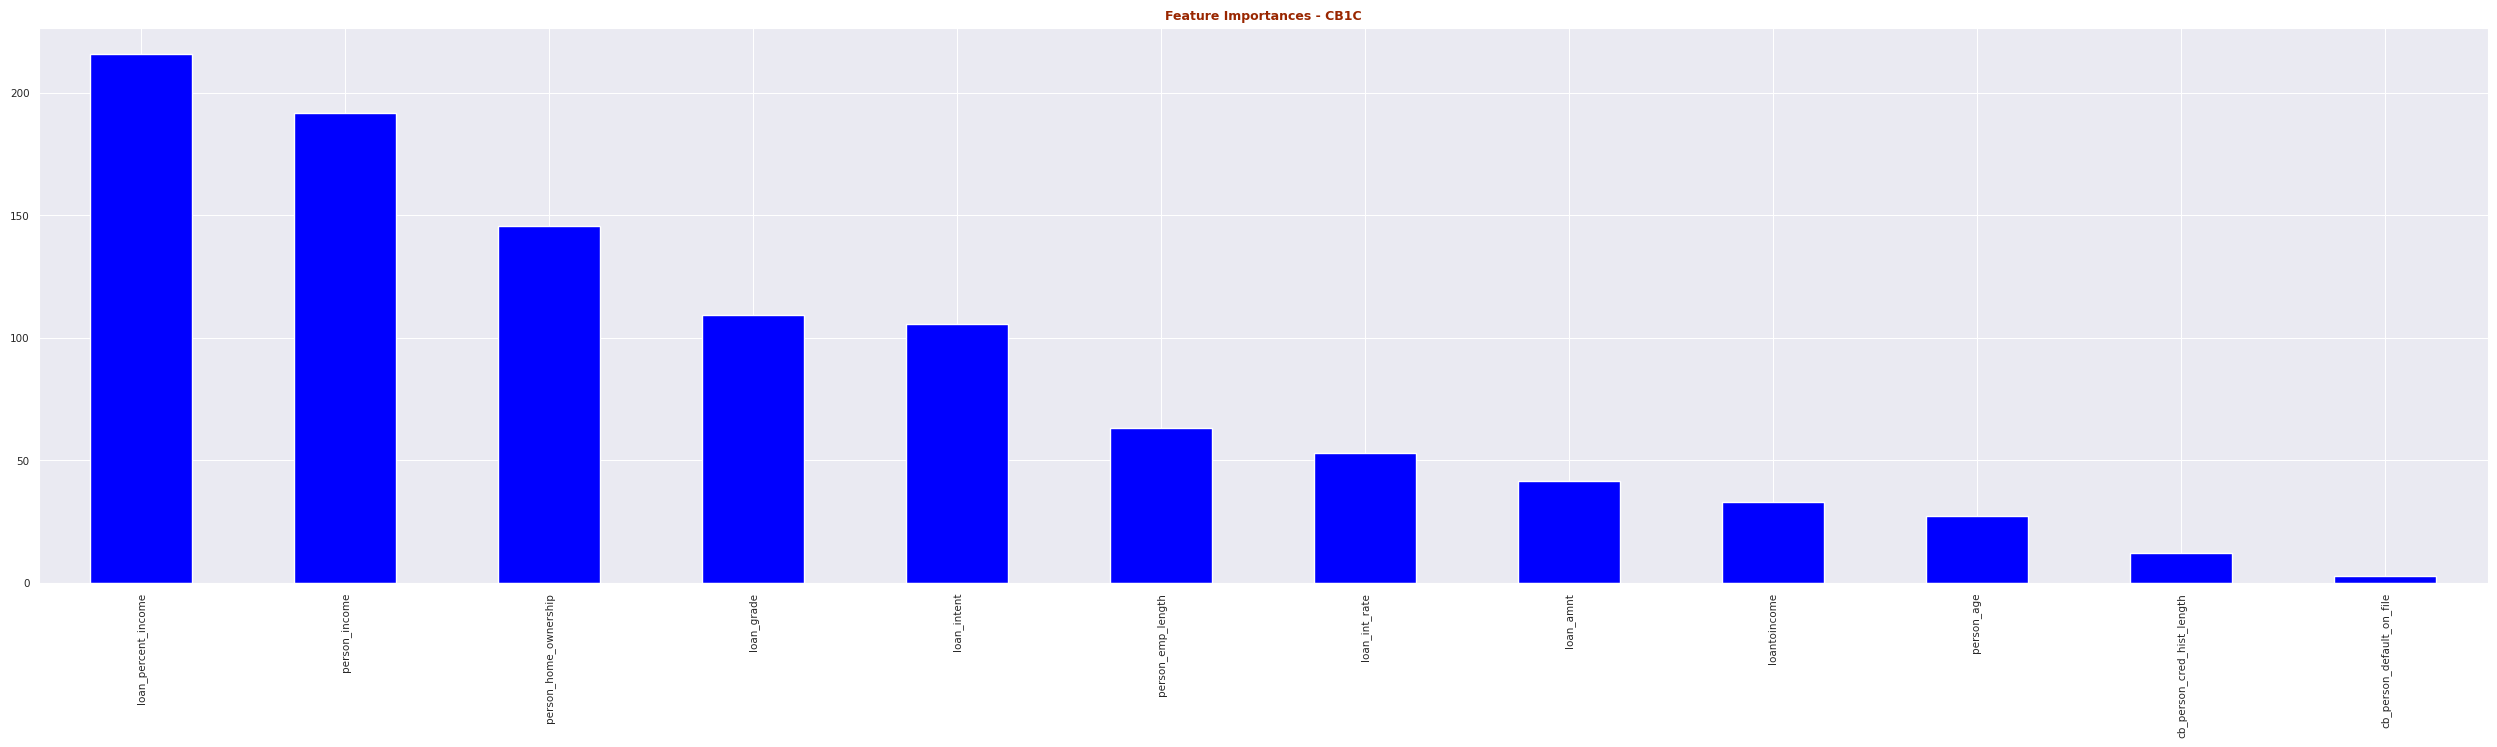



---> 0.968461 +- 0.002915 | OOF
---> 0.985518 +- 0.002121 | Train
---> Max best iteration = 1,270
---> Collecting original predictions

CPU times: user 1h 3min 58s, sys: 1min 55s, total: 1h 5min 53s
Wall time: 27min 53s


In [15]:
%%time

# Model training:-
drop_cols = ["Source", "id", "Id", "Label", CFG.target, "fold_nb"]

for method, mymodel in tqdm(Mdl_Master.items()):

    PrintColor(f"\n{'=' * 20} {method.upper()} MODEL TRAINING {'=' * 20}\n")

    md = \
    ModelTrainer(
        problem_type   = "binary",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = True if CFG.nb_orig > 0 else False,
        orig_all_folds = CFG.orig_all_folds,
        metric_lbl     = "auc",
        drop_cols      = drop_cols,
        )

    sel_mdl_cols = list(Xtest.columns)
    
    PrintColor(f"Selected columns = {len(sel_mdl_cols) :,.0f}", color = Fore.RED)
    SelMdlCols[method] = sel_mdl_cols, cat_mdl_cols

    fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter =  \
    md.MakeOfflineModel(
        Xtrain[sel_mdl_cols].copy(),
        deepcopy(ytrain),
        ygrp,
        Xtest[sel_mdl_cols].copy(),
        clone(mymodel),
        method,
        test_preds_req   = True,
        ftreimp_plot_req = CFG.ftre_imp_req,
        ntop = 50,
    )

    OOF_Preds[method]    = oof_preds
    Mdl_Preds[method]    = test_preds
    FittedModels[method] = fitted_models
    FtreImp[method]      = ftreimp

    del fitted_models, oof_preds, test_preds, ftreimp, sel_mdl_cols
    print()
    collect();

_ = utils.CleanMemory();


## **ENSEMBLE**

In [16]:
%%time 

len_train  = len(Xtrain.loc[Xtrain.Source == "Competition"])
oof_preds  = pd.DataFrame.from_dict(OOF_Preds, orient = "columns").iloc[0 : len_train]
oof_preds[CFG.target] = ytrain.iloc[0 : len_train]
oof_preds["fold_nb"]  = ygrp.iloc[0 : len_train]

mdl_preds  = pd.DataFrame.from_dict(Mdl_Preds, orient = "columns")
sel_cols   = mdl_preds.columns

test_preds = 0
scores     = 0
ens_preds  = np.zeros(len(oof_preds))
mycv       = PDS(ygrp.iloc[0 : len_train])

PrintColor(f"\n ----- Logistic Ensemble ----- \n") 

for fold_nb, (train_idx, dev_idx) in enumerate(mycv.split(oof_preds, oof_preds[CFG.target])):
    Xtr  = oof_preds.iloc[train_idx][sel_cols]
    ytr  = oof_preds.loc[train_idx, CFG.target]
    Xdev = oof_preds.iloc[dev_idx][sel_cols]
    ydev = oof_preds.loc[dev_idx, CFG.target]
    
    model = LRC(C = 0.10, random_state = CFG.state, max_iter = 5000)
    model.fit(Xtr, ytr)
    
    dev_preds  = model.predict_proba(Xdev)[:,1]
    test_preds = test_preds + (model.predict_proba(mdl_preds)[:,1] / CFG.n_splits)
    score      = utils.ScoreMetric(ydev, dev_preds)
    PrintColor(f"---> Fold{fold_nb} Score = {score:.6f}", color = Fore.CYAN)
    scores = scores + (score / CFG.n_splits)
    
    ens_preds[dev_idx] = dev_preds
    
PrintColor(f"\n---> Mean Score = {scores:.6f}")



 ----- Logistic Ensemble ----- 

---> Fold0 Score = 0.967473
---> Fold1 Score = 0.962488
---> Fold2 Score = 0.973035
---> Fold3 Score = 0.972580
---> Fold4 Score = 0.969319
---> Fold5 Score = 0.968415
---> Fold6 Score = 0.970338
---> Fold7 Score = 0.971873
---> Fold8 Score = 0.968072
---> Fold9 Score = 0.967219

---> Mean Score = 0.969081
CPU times: user 2.54 s, sys: 1.9 s, total: 4.45 s
Wall time: 1.16 s


# **CLOSURE**

In [17]:
%%time 

try:
    oof_preds.assign(**{"Ensemble": ens_preds}).\
    to_csv(
        os.path.join(CFG.op_path, f"OOF_Preds_{CFG.model_label}{CFG.model_id}.csv")
    )

    mdl_preds.assign(**{"Ensemble": test_preds}).\
    to_csv(
        os.path.join(CFG.op_path, f"Mdl_Preds_{CFG.model_label}{CFG.model_id}.csv")
    )
    
except:
    pass

pp.sub_fl[CFG.target] = test_preds
pp.sub_fl.to_csv(
    os.path.join(CFG.op_path, f"submission.csv"), index = None
)

print()
!ls
print()
!head submission.csv

_ = utils.CleanMemory()
print()


Mdl_Preds_MLV1_2.csv  __notebook__.ipynb  submission.csv
OOF_Preds_MLV1_2.csv  catboost_info	  xgb_optimize.log

id,loan_status
58645,0.9753788308264628
58646,0.0251525143319089
58647,0.36799054651778945
58648,0.02219875746287531
58649,0.02936405698688866
58650,0.9664650900043359
58651,0.02031052594721007
58652,0.02159907305919852
58653,0.10120539891724419

CPU times: user 1.52 s, sys: 133 ms, total: 1.65 s
Wall time: 4.01 s


# **NEXT STEPS**

1. Development of better features and data engineering  <br>
2. Better model parameters <br>
3. Incoproration of ideas from across public discussions and forums <br>
4. Incorporation of my work ideas going ahead <br>

**Best of luck and happy learning!**